# Investigating RNNs and RL using the N-back cognitive task

**NMA 2023 Group 1 Project**

__Content creators:__ Aland Astudillo, Campbell Border, Disheng, Julia Yin, Koffivi Gbagbe, Rishabh Mallik, Shuwen Liu, Zelin Zhang

__Pod TA:__ Suryanarayanan Nagar Anthel Venkatesh

__Project Mentor:__ 

---
## Abstract

This study examines the varying methodologies for training neural networks on one-step lookahead tasks, specifically the N-back task, a widely accepted measure of participant's working memory. Our research centers on understanding how different training techniques, namely supervised learning (SL) and reinforcement learning (RL), influence the learning trajectories of neural networks with identical architectures. 

Our hypothesis posits that while the different learning strategies may initially result in diverse short-term representations, these disparities will gradually converge to similar outcomes. Moreover, we anticipate that a Multi Layer Perceptron (MLP) will demonstrate a higher degree of correlation between the learning strategies compared to a Recurrent Neural Network (RNN). 

To test these propositions, two models, an MLP and an RNN, were designed and trained using both RL (Q-learning) and SL (classification) strategies. We recorded the weight matrices at each step and used Principal Component Analysis (PCA) and Canonical Correlation Analysis (CCA) to ascertain the correlation between them. We calibrated the hyperparameters across all models to facilitate a fair comparison. 

Notwithstanding these results, our study has certain limitations that pave the way for future research. We plan to investigate the relationship between the number of recurrent layers in an RNN and its recall capabilities of earlier stimuli. Additionally, we aim to explore other RNN architectures, such as the Long Short Term Memory (LSTM), Gated Recurrent Units (GRU), or Transformers. Finally, we plan to compare artificial agents in more complex and dynamic memory tasks, such as varying length N-back tasks. 

Our current findings offer valuable insights into the dynamics of neural network learning in working memory tasks, which can aid in refining the application of such networks in cognitive science and artificial intelligence.

---
## Project Design


---
## Setup

### Install Dependencies

In [1]:
# @title Install dependencies
!pip install jedi --quiet
!pip install --upgrade pip setuptools wheel --quiet
!pip install numpy==1.23.3 --quiet --ignore-installed
!pip install gymnasium --quiet
!pip install seaborn --quiet

In [1]:
# @title Imports

import time
import random
import string
import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns

import gymnasium as gym
from gymnasium import spaces

import torch
from torch import nn
from torch import optim

import seaborn as sns
import matplotlib.pyplot as plt

### Figure settings

In [3]:
# @title Figure settings
from IPython.display import clear_output, display, HTML
%matplotlib inline
# sns.set()

---

## Datasets

- Human Connectome Project Working Memory (HCP WM) task ([NMA-CN HCP notebooks](https://github.com/NeuromatchAcademy/course-content/tree/master/projects/fMRI))

1200 subjects, each subject experience 8 blocks of 2-back and 8 blocks of 0-back.

## N-back Tasks

In the N-back task, participants view a sequence of stimuli, one per time, and are asked to categorize each stimulus as being either match or non-match. Stimuli are usually numbers, and feedbacks are given at both timestep and trajectory levels.

In a typical neuro setup, both accuracy and response time are measured, but here, for the sake of brevity, we focus only on accuracy of responses.

- 2 back working memory task:

The second condition is a 2-Back condition. During such a block, the subject is presented with a sequence of 10 images and must respond if each image is identical to the one 2 positions earlier or not (figure, right). At the beginning of the block there is a cue screen informing the subject that the upcoming stimuli are part of the 2-Back protocol. The timing of the cue screen, the presentation of the 10 stimulus images and of the response interval are identical to that of the 0-Back condition.

- 0-back control memory task:

The first is a match-to-sample condition (termed in the following text as 0-Back) during which a cue “Target” image is presented at the beginning of a block and which the subject has been instructed to memorize. Then a sequence of 10 images is presented. 


Any dataset that used cognitive tests would work.
Question: limit to behavioral data vs fMRI?
Question: Which stimuli and actions to use?
classic tests can be modeled using 1) bounded symbolic stimuli/actions (e.g., A, B, C), but more sophisticated one would require texts or images (e.g., face vs neutral images in social stroop dataset)
The HCP dataset from NMA-CN contains behavioral and imaging data for 7 cognitive tests including various versions of N-back.


Details of the tMEG Working Memory task

Working memory is assessed using an N-back task in which participants are asked to monitor
sequentially presented pictures. Participants are presented with blocks of trials that consisted of
pictures of tools or faces. Within each run, the 2 different stimulus types are presented in
separate blocks. Also, within each run, ½ of the blocks use a 2-back working memory task and
½ use a 0-back working memory task (as a working memory comparison). Participants are
instructed to press a button for every picture. If the currently presented picture matches the
cued picture (0-Back) or the same picture that was presented two pictures before (2-Back),
subjects press one button with their right index finger. For non-matching pictures, participants
press a second button with their right middle finger. Two runs are performed, 16 blocks each,
with a bright fixation "rest" on dark background for 15 seconds between blocks. 

- Special modelling of images (we are probably not going to model this)

There are 2 different categories of images used in this experiment: images of faces and tools.
Each block contains images from a single category. Some of the images in the non-matched
trials have been characterized as “Lure”. These images have been selected so that they have
common features with the target image, but are still different. These trials as flagged as “Lure”.
I


https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf Page 72

---
## Implementation scheme

### N-back environment
The following cell implments N-back envinronment, that we later use to train a RL agent on human data. It is capable of performing two kinds of simulation:
- rewards the agent once the action was correct (i.e., a normative model of the environment).
- receives human data (or mock data if you prefer), and returns what participants performed as the observation. This is more useful for preference-based RL.

In [25]:
# @title Define environment

# N-back environment
class NBack(gym.Env):

    # N = 2
    # step_count =        [ 0  1  2  3  4  5  6 ]
    # sequence =          [ a  b  c  d  a  d  a ]
    # correct actions =   [ ~  ~  0  0  0  1  1 ]

    # actions =           [ ~  ~  1  0  0  1  0 ]
    # reward_class =      [ ~  ~  FP TN TN TP FN]
    # reward =            [ ~  ~  -1  0  0  1 -1]

  ACTIONS = ['match', 'non-match']

  # Rewards input is structured as (TP, TN, FP, FN) (positive being matches)
  def __init__(self, 
               N=2, 
               total_steps=10,
               total_blocks=8, 
               memory_capacity = 5,
               stimulus_choices = list(string.ascii_lowercase[:5]),
               human_data = None):

    # basic setting
    self.N = N                                                                  # N in N-back task
    self.total_steps = total_steps                                              # how many image showed per block
    self.total_blocks = total_blocks                                            # how many blocks per participant

    self.stimulus_choices = stimulus_choices                                    # what stimuli are available
    self.num_stim = len(stimulus_choices)                                       # the count of possible stimuli

    self.memory_capacity = memory_capacity                                      # memory capacity of that participant

    # Define rewards, observation space and action space
    self.reward_range = spaces.Discrete(2)                                      # Range of rewards based on inputs, it is either 0 or 1
    self.action_space = spaces.Discrete(2)                                      # 0 (No match) or 1 (Match)
    self.correct_actions = np.zeros(shape = (total_steps)).astype('int')         # will be filled in the `reset()`

    self.sequence = np.zeros(shape = (total_steps)).astype('int')      # will be filled in the `reset()`, represent the true input sequence
    self.observations = np.zeros(shape = (memory_capacity, self.num_stim)).astype('int')  # will be filled in the `reset()`, represent the true input sequence in memory
    self.step_count = 0                                                         # num of step count 
    self._action_history = []                                                   # history of agent's action

    self.total_reward = 0

    # copy and pasted from template 
    # whether mimic humans or reward the agent once it responds optimally.
    if human_data is None:
      self._imitate_human = False
      self.human_data = None
      self.human_subject_data = None
    else:
      self._imitate_human = True
      self.human_data = human_data
      self.human_subject_data = None


  def reset(self, seed = None):
    
    # Seed RNG
    super().reset(seed=seed)

    # clearing the action history and reset step count
    self._action_history = []
    self.step_count = 0
    self.total_reward = 0

    # Generate sequence of length self.episode_length, using one hot encoding
    sequence = [random.randrange(self.num_stim) for i in range(self.total_steps)]
    self.sequence = sequence

    # generate observations
    self.observations = self._get_observations()
    self.correct_actions = self._get_correct_actions()

    return self.observations, self._get_info()

  def step(self, action):

    # move one step further
    self.step_count += 1
    #print('I am watching image # {}.'.format(self.step_count))

    # Calculate reward, step_count - 1 because we are not counting zero in task
    if (action == self.correct_actions[self.step_count - 1]): # Match
      reward = 1
      if action == 1: # true match
        self._action_history.append('TP')
      else:
        self._action_history.append('TN')
    else: # No match
      reward = 0
      if action == 1: # true match
        self._action_history.append('FP')
      else:
        self._action_history.append('FN')

    self.total_reward += reward
    
    # get the sequence 
    self.observations = self._get_observations()

    # check for ending
    if self.step_count >= self.total_steps:
      done = True
    else:
      done = False

    return self.observations, reward, done, self._get_info()
  
  def _get_observations(self):
    observations = np.zeros(shape = (self.memory_capacity, self.num_stim)).astype('int')
    if self.step_count >= self.memory_capacity:
      for i in range(self.memory_capacity):
        observations[i, self.sequence[self.step_count - self.memory_capacity + i ]] = 1
    else:
        for ind, i in enumerate(range(self.memory_capacity - self.step_count - 1, self.memory_capacity)):
          observations[i, self.sequence[ind]] = 1
    return observations

  def _get_correct_actions(self):
      correct_actions = np.array([int(self.sequence[i] == self.sequence[i + self.N]) for i in range(self.total_steps - self.N)])
      correct_actions = np.concatenate((np.ones(self.N).astype('int') * 10, correct_actions))
      return correct_actions
  
  def _get_info(self):
    info = {
        'step_count': self.step_count,
        'total_reward': self.total_reward,
        'sequence': self.sequence,
        'observations': self.observations,
        'action_history': self._action_history,
        }
    return info

### Test N-back environment

In [5]:
env = NBack()

for tid in range(10):
    env.reset()
    print(env.sequence)
    print(env.correct_actions)

[4, 4, 3, 1, 4, 2, 1, 3, 4, 0]
[10 10  0  0  0  0  0  0  0  0]
[4, 2, 3, 1, 1, 1, 2, 0, 4, 3]
[10 10  0  0  0  1  0  0  0  0]
[0, 1, 3, 1, 3, 3, 0, 4, 0, 0]
[10 10  0  1  1  0  0  0  1  0]
[0, 0, 1, 4, 4, 4, 4, 2, 2, 2]
[10 10  0  0  0  1  1  0  0  1]
[3, 4, 3, 3, 0, 1, 1, 1, 4, 3]
[10 10  1  0  0  0  0  1  0  0]
[4, 1, 2, 2, 1, 4, 4, 1, 2, 3]
[10 10  0  0  0  0  0  0  0  0]
[0, 0, 0, 3, 3, 1, 0, 3, 3, 0]
[10 10  1  0  0  0  0  0  0  0]
[3, 1, 2, 2, 1, 3, 4, 0, 4, 0]
[10 10  0  0  0  0  0  0  1  1]
[2, 3, 0, 0, 2, 4, 3, 0, 0, 1]
[10 10  0  0  0  0  0  0  0  0]
[0, 2, 0, 0, 3, 4, 0, 3, 0, 0]
[10 10  1  0  0  0  0  0  1  0]


In [188]:
# @title Test environment

env = NBack()
env.reset()
print(env.sequence)
print(env.correct_actions)

done = False
while not done:
  observations, reward, done, info = env.step(1)
  print(done, info['step_count'], info['observations'])

[3, 4, 0, 3, 2, 0, 1, 2, 0, 4]
[10 10  0  0  0  0  0  0  0  0]
I am watching image # 1.
False 1 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]
I am watching image # 2.
False 2 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
I am watching image # 3.
False 3 [[0 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 0 1 0]]
I am watching image # 4.
False 4 [[0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]]
I am watching image # 5.
False 5 [[0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]]
I am watching image # 6.
False 6 [[0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [1 0 0 0 0]]
I am watching image # 7.
False 7 [[1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]]
I am watching image # 8.
False 8 [[0 0 0 1 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]]
I am watching image # 9.
False 9 [[0 0 1 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [1 0 0 0 0]]
I am watching image # 10.
True 10 [[1 0 0 0 0]

### Define a random agent

In [185]:
# Random agent
class RandomAgent(nn.Module):

  def __init__(self, environment_spec):
    """Gets the number of available actions from the environment spec."""
    self._num_actions = len(environment_spec.ACTIONS)

  def select_action(self, observation):
    """Selects an action uniformly at random."""
    action = np.random.randint(self._num_actions)
    return action

  def observe_first(self, timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def observe(self, action, next_timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def update(self):
    """Does not update as the RandomAgent does not learn from data."""
    pass

### Test random agent

In [233]:
env = NBack()
agent = RandomAgent(env)

trial_num = 1000
trace_trials = {'reward': [], 'action_history': [], 'true_reward': [], 'action_value': []}
for tid in range(trial_num):
    env.reset()
    done = False
    while not done:
        action = agent.select_action(env.observations)
        trace_trials['action_history'].append(action)
        _, _, done, _ = env.step(action)
    trace_trials['reward'].append(env.total_reward)
    trace_trials['true_reward'].append(env.correct_actions)
    trace_trials['action_value'].append(env._action_history)


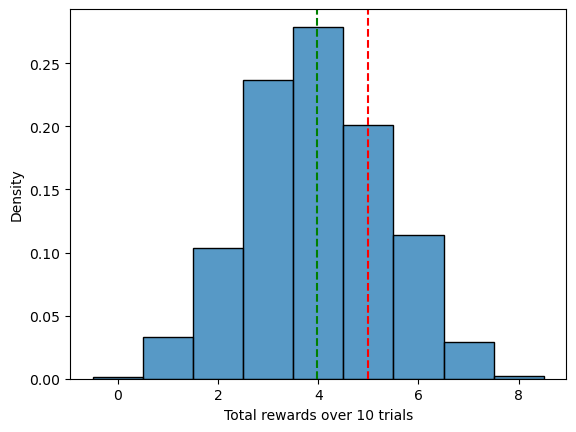

In [228]:
plt.subplot(1, 1, 1)
sns.histplot(trace_trials['reward'], stat="density", bins=4, discrete=True)
#plt.axvline(5, color='r', linestyle='--')
plt.axvline(np.mean(trace_trials['reward']), color='g', linestyle='--')
plt.xlabel('Total rewards over 10 trials')
plt.ylabel('Density')
plt.show()

In [229]:
# whether random choice is balanced
trace_trials['action_history']
print([trace_trials['action_history'].count(0), trace_trials['action_history'].count(1)])

[5052, 4948]


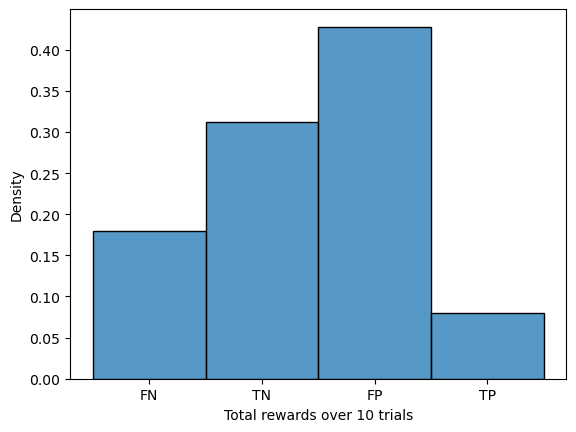

In [236]:
total_actions = sum(trace_trials['action_value'], [])

plt.subplot(1, 1, 1)
sns.histplot(total_actions, stat="density", bins=4, discrete=True)
plt.xlabel('Total rewards over 10 trials')
plt.ylabel('Density')
plt.show()

In [216]:
# frequency of possible correct match
total_possible = np.sum(trace_trials['true_reward']) - 10 * 2 * len(trace_trials['true_reward'])
average_possible = total_possible / len(trace_trials['true_reward'])
print(total_possible, average_possible)

1593 1.593


### Deep Learning Agent

In [152]:
class DQN(nn.Module):
# Neural network representing the Q-function

  def __init__(self, num_obs, num_actions, hidden_sizes=[], actv="ReLU()"):

    super().__init__()

    self.num_obs = num_obs
    self.num_actions = num_actions
    self.hidden_sizes = hidden_sizes
    self.mlp = nn.Sequential()

    # Create net
    input_size = self.num_obs # Initialize the temporary input feature to each layer
    
    for i in range(len(hidden_sizes)): # Loop over layers and create each one
        
        # Add linear layer
        output_size = hidden_sizes[i] # Assign the current layer hidden unit from list
        layer = nn.Linear(input_size, output_size)
        input_size = output_size # Assign next layer input using current layer output
        self.mlp.add_module('Linear_%d'%i, layer) # Append layer to the model

        # Add activation function
        actv_layer = eval('nn.%s'%actv) # Assign activation function (eval allows us to instantiate object from string)
        self.mlp.add_module('Activation_%d'%i, actv_layer) # Append activation to the model with a name
        #print(input_size, output_size)

    out_layer = nn.Linear(output_size, self.num_actions) # Create final layer
    self.mlp.add_module('Output_Linear', out_layer) # Append the final layer

  def forward(self, x):
    x = torch.tensor(x, dtype=torch.float)
    return self.mlp(x)

In [218]:
# test DQN
env = NBack()
model = DQN(env.num_stim * env.memory_capacity, 2, [32, 32])
print(model)

out = model.forward(states)

DQN(
  (mlp): Sequential(
    (Linear_0): Linear(in_features=25, out_features=32, bias=True)
    (Activation_0): ReLU()
    (Linear_1): Linear(in_features=32, out_features=32, bias=True)
    (Activation_1): ReLU()
    (Output_Linear): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [282]:
print(out.shape)
print(out.argmax().item())

torch.Size([64, 2])
9


In [330]:
class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, next_state, reward, done):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, next_state, reward, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states, actions, next_states, rewards, dones = zip(*batch)

        states = np.array(states)
        states = states.reshape(states.shape[0], states.shape[1] * states.shape[2])

        next_states = np.array(next_states)
        next_states = states.reshape(next_states.shape[0], next_states.shape[1] * next_states.shape[2])

        return states, np.array(actions), next_states, np.array(rewards), np.array(int(dones == 'True'))

    def __len__(self):
        return len(self.memory)

In [331]:
# test replay memory
env = NBack()
memory = ReplayMemory(1000)

state, _ = env.reset()
action = 0
next_state = state.copy()
reward = 0
done = False

memory.push(state, action, next_state, reward, done)
memory.__len__()
for i in range(100):
    #print(memory.__len__())
    memory.push(state, action, next_state, reward, done)

states, actions, next_states, rewards, dones = memory.sample(10)
print(torch.from_numpy(states).shape)
print(actions)
print(next_states.shape)
print(rewards)
print(dones)

torch.Size([10, 25])
[0 0 0 0 0 0 0 0 0 0]
(10, 25)
[0 0 0 0 0 0 0 0 0 0]
0


In [165]:
def train(model, memory, optimizer, criterion, batch_size, gamma):
    # training function

    if len(memory) < batch_size:
        return np.array([0])
    
    states, actions, next_states, rewards, dones = memory.sample(batch_size)

    states = torch.from_numpy(states)
    actions = torch.from_numpy(actions)
    next_states = torch.from_numpy(next_states)
    rewards = torch.from_numpy(rewards)
    dones = torch.from_numpy(dones)
    #print(states, actions, next_states, rewards, dones)

    q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    #print(q_values)
    #.gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = model(next_states).max(1)[0]

    target_q_values = rewards + gamma * next_q_values * (1 - dones)

    loss = criterion(q_values, target_q_values.detach())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.detach()


In [136]:
## test train
env = NBack()
model = DQN(env.num_stim * env.memory_capacity, 2, [32, 32])
print(model)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
batch_size = 10
gamma = 0

'''
#train(model, memory, optimizer, criterion, batch_size, gamma)

states, actions, next_states, rewards, dones = memory.sample(batch_size)

states = torch.from_numpy(states)
actions = torch.from_numpy(actions)
next_states = torch.from_numpy(next_states)
rewards = torch.from_numpy(rewards)
dones = torch.from_numpy(dones)
#print(states, actions, next_states, rewards, dones)

q_values = model(states.clone().detach()).gather(1, actions.unsqueeze(1)).squeeze(1)
print(q_values)

next_q_values = model(next_states).max(1)[0]

target_q_values = rewards + gamma * next_q_values * (1 - dones)

print(q_values, next_q_values, target_q_values)

#loss = criterion(q_values, target_q_values.detach())

#optimizer.zero_grad()
#loss.backward()
#optimizer.step()
'''

for i in range(100):
    train(model, memory, optimizer, criterion, batch_size, gamma)


32 32
32 32
DQN(
  (mlp): Sequential(
    (Linear_0): Linear(in_features=25, out_features=32, bias=True)
    (Activation_0): ReLU()
    (Linear_1): Linear(in_features=32, out_features=32, bias=True)
    (Activation_1): ReLU()
    (Output_Linear): Linear(in_features=32, out_features=2, bias=True)
  )
)


/var/folders/g4/tfd3sjg137dg4c41qxh6l7zw0000gn/T/ipykernel_13329/1656244064.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float)


In [284]:
def exec_training(model, 
                  env, 
                  gamma=0, 
                  num_episodes = 100, 
                  capacity = 1000, 
                  batch_size = 64, 
                  lr = 0.001, 
                  eps_max = 0.08, 
                  eps_min = 0.01,
                  eps_step = 0.01):

    # Create an instance of the replay memory
    memory = ReplayMemory(capacity)

    # Set up the optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # define tracking
    trace_trials = {'reward': [], 'action_history': [], 'true_reward': [], 'action_value': []}
    loss_list = []

    # Training loop
    for episode in range(num_episodes):

        state, info = env.reset()
        done = False
        
        while not done:

            # Select an action using epsilon-greedy policy
            epsilon = max((eps_min), eps_max - (eps_step * episode))
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = model(torch.from_numpy(state.flatten()))
                    action = q_values.argmax().item()

            # Take the selected action and observe the next state and reward
            next_state, reward, done, info = env.step(action)

            # Store the transition in the replay memory
            memory.push(state, action, next_state, reward, done)

            # Move to the next state
            state = next_state

            # Train the model
            loss = train(model, memory, optimizer, criterion, batch_size, gamma)

            loss_list.append(loss.mean())
            trace_trials['action_history'].append(action)

        #rewards_list.append(total_reward)
        #actions = np.array(actions[2:])
        #correct_actions = env.correct_actions
        #tps[episode] = np.dot(actions, correct_actions) / sum(correct_actions)
        #fps[episode] = np.dot(actions, 1 - correct_actions) / sum(1 - correct_actions)
        #fns[episode] = np.dot(1 - actions, correct_actions) / sum(correct_actions)
        #correct[episode] = sum(actions == correct_actions) / env.num_trials

        trace_trials['reward'].append(env.total_reward)
        trace_trials['true_reward'].append(env.correct_actions)
        trace_trials['action_value'].append(env._action_history)

    return loss_list, trace_trials

In [285]:
# test exec_training

env = NBack()
model = DQN(env.num_stim * env.memory_capacity, 2, [32, 32])
#print(model)

for num_episodes in [5, 10, 50, 100, 500, 1000]:

    # use default env
    env = NBack()

    # define DQN
    input_size = env.num_stim * env.memory_capacity
    output_size = env.action_space.n
    model = DQN(env.num_stim * env.memory_capacity, 2, [32, 32])

    # define q-learning parameters
    gamma = 0.01
    loss_list, trace_trials = exec_training(model, env, gamma, num_episodes)


/var/folders/g4/tfd3sjg137dg4c41qxh6l7zw0000gn/T/ipykernel_13329/2379766893.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float)


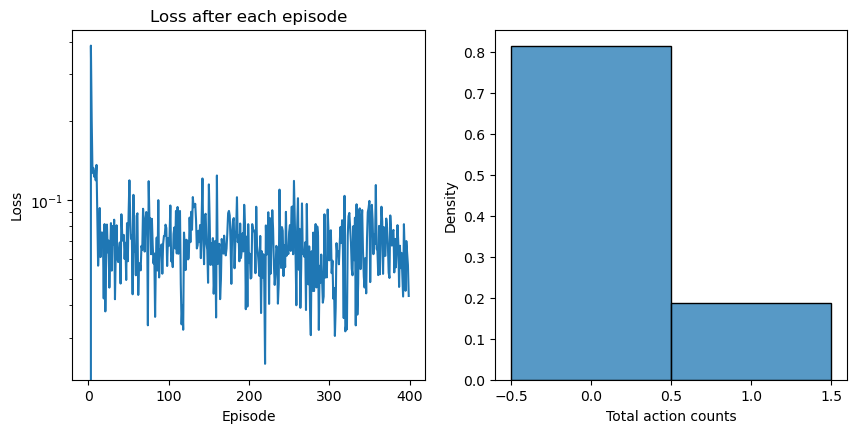

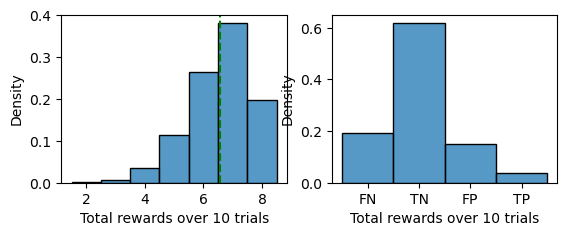

In [288]:
# do plots 

fig = plt.figure(figsize=(10, 10))

# Loss
plt.subplot(2, 2, 1)
plt.plot(loss_list[::25], '-')
plt.title("Loss after each episode")
plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("Episode")

# Percentage correct
step = 1
plt.subplot(2, 2, 2)
sns.histplot(trace_trials['action_history'], stat="density", bins=4, discrete=True)
#plt.axvline(5, color='r', linestyle='--')
plt.xlabel('Total action counts')
plt.ylabel('Density')
plt.show()


# Reward
plt.subplot(2, 2, 3)
sns.histplot(trace_trials['reward'], stat="density", bins=4, discrete=True)
#plt.axvline(5, color='r', linestyle='--')
plt.axvline(np.mean(trace_trials['reward']), color='g', linestyle='--')
plt.xlabel('Total rewards over 10 trials')
plt.ylabel('Density')

# TPs, FPs, FNs
plt.subplot(2, 2, 4)
total_actions = sum(trace_trials['action_value'], [])
sns.histplot(total_actions, stat="density", bins=4, discrete=True)
plt.xlabel('Total rewards over 10 trials')
plt.ylabel('Density')


plt.show()


### Define a Recurrent Deep Q-learning Agent (RDQN)

In [390]:
class RNN(nn.Module):
  # RNN module: now is one RNN layer + 1 linear layer

  def __init__(self, num_obs, num_actions, hidden_size, layerdim = 1):
    super().__init__()

    self.num_obs = num_obs
    self.num_actions = num_actions
    self.hidden_size = hidden_size
    self.layerdim = layerdim

    # Create net
    #input_size = self.num_obs # Initialize the temporary input feature to each layer
    self.rnn = nn.RNN(num_obs, hidden_size, layerdim, batch_first=True, nonlinearity='relu')
    self.fc = nn.Linear(hidden_size, num_actions)

  def forward(self, x):
      #h = torch.zeros(self.layerdim, x.size(0), self.hidden_size).requires_grad_()
      #print(x.shape, h.shape)
      outp, h = self.rnn(x)
      outp = self.fc(outp)
      #print(outp)
      return outp

In [392]:
# test RNN construction

env = NBack()

# define DQN
input_size = env.num_stim * env.memory_capacity
output_size = env.action_space.n
hidden_size = 32
model = RNN(input_size, output_size, hidden_size)

print(model)


outp = model(torch.from_numpy(states).to(torch.float32))
print(outp)

outp.gather(1, actions.unsqueeze(1)).squeeze(1)
print(outp.argmax().item())

RNN(
  (rnn): RNN(25, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


TypeError: expected np.ndarray (got Tensor)

In [393]:
def train_rnn(model, memory, optimizer, criterion, batch_size, gamma):
    # training function

    if len(memory) < batch_size:
        return np.array([0])
    
    states, actions, next_states, rewards, dones = memory.sample(batch_size)

    states = torch.from_numpy(states).to(torch.float32)
    actions = torch.from_numpy(actions).to(torch.long)
    next_states = torch.from_numpy(next_states).to(torch.float32)
    rewards = torch.from_numpy(rewards).to(torch.float32)
    dones = torch.from_numpy(dones).to(torch.long)
    #print(actions)

    q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    #print(q_values)
    #.gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = model(next_states).max(1)[0]

    target_q_values = rewards + gamma * next_q_values * (1 - dones)

    loss = criterion(q_values, target_q_values.detach())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.detach()

In [394]:
## test train_rnn
env = NBack()

# define DQN
input_size = env.num_stim * env.memory_capacity
output_size = env.action_space.n
model = RNN(env.num_stim * env.memory_capacity, 2, 2)

print(model)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
batch_size = 10
gamma = 0


for i in range(100):
    train_rnn(model, memory, optimizer, criterion, batch_size, gamma)


RNN(
  (rnn): RNN(25, 2, batch_first=True)
  (fc): Linear(in_features=2, out_features=2, bias=True)
)


In [400]:
def exec_training_rnn(model, 
                  env, 
                  gamma=0, 
                  num_episodes = 100, 
                  capacity = 1000, 
                  batch_size = 64, 
                  lr = 0.001, 
                  eps_max = 0.08, 
                  eps_min = 0.01,
                  eps_step = 0.01):

    # Create an instance of the replay memory
    memory = ReplayMemory(capacity)

    # Set up the optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # define tracking
    trace_trials = {'reward': [], 'action_history': [], 'true_reward': [], 'action_value': []}
    loss_list = []

    # Training loop
    for episode in range(num_episodes):

        state, info = env.reset()
        done = False
        
        while not done:

            # Select an action using epsilon-greedy policy
            epsilon = max((eps_min), eps_max - (eps_step * episode))
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = model(torch.from_numpy(state.reshape(1, state.shape[0] * state.shape[1])).to(torch.float32))
                    action = q_values.argmax().item()
                    print(action)

            # Take the selected action and observe the next state and reward
            next_state, reward, done, info = env.step(action)

            # Store the transition in the replay memory
            memory.push(state, action, next_state, reward, done)

            # Move to the next state
            state = next_state

            # Train the model
            loss = train_rnn(model, memory, optimizer, criterion, batch_size, gamma)

            loss_list.append(loss.mean())

        #rewards_list.append(total_reward)
        #actions = np.array(actions[2:])
        #correct_actions = env.correct_actions
        #tps[episode] = np.dot(actions, correct_actions) / sum(correct_actions)
        #fps[episode] = np.dot(actions, 1 - correct_actions) / sum(1 - correct_actions)
        #fns[episode] = np.dot(1 - actions, correct_actions) / sum(correct_actions)
        #correct[episode] = sum(actions == correct_actions) / env.num_trials

        trace_trials['reward'].append(env.total_reward)
        trace_trials['true_reward'].append(env.correct_actions)
        trace_trials['action_value'].append(env._action_history)

    return loss_list, trace_trials

In [401]:
# test exec_training

env = NBack()

# define RDQN
input_size = env.num_stim * env.memory_capacity
output_size = env.action_space.n
model = RNN(env.num_stim * env.memory_capacity, 2, 2)


for num_episodes in [5, 10, 50, 100, 500, 1000]:

    # use default env
    env = NBack()

    # define DQN
    input_size = env.num_stim * env.memory_capacity
    output_size = env.action_space.n

    # define q-learning parameters
    gamma = 0.01
    loss_list, trace_trials = exec_training_rnn(model, env, gamma, num_episodes)


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


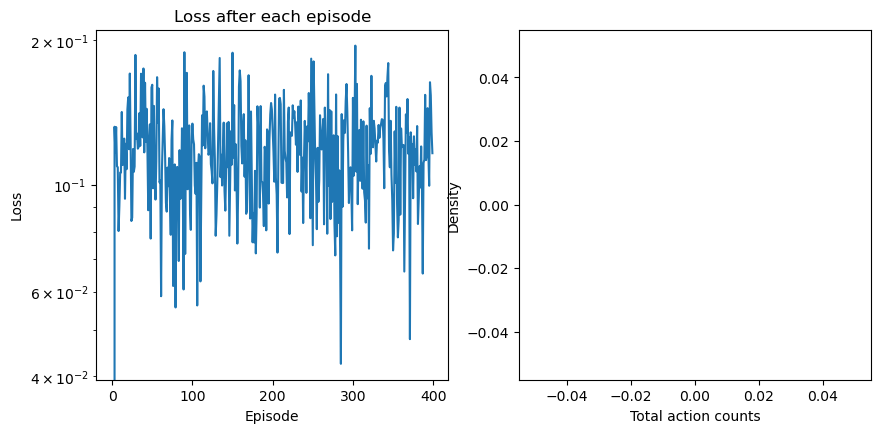

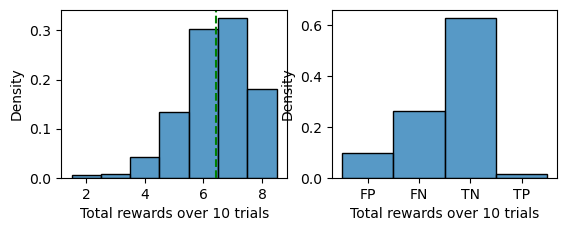

In [402]:
# do plots 

fig = plt.figure(figsize=(10, 10))

# Loss
plt.subplot(2, 2, 1)
plt.plot(loss_list[::25], '-')
plt.title("Loss after each episode")
plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("Episode")

# Percentage correct
step = 1
plt.subplot(2, 2, 2)
sns.histplot(trace_trials['action_history'], stat="density", bins=4, discrete=True)
#plt.axvline(5, color='r', linestyle='--')
plt.xlabel('Total action counts')
plt.ylabel('Density')
plt.show()


# Reward
plt.subplot(2, 2, 3)
sns.histplot(trace_trials['reward'], stat="density", bins=4, discrete=True)
#plt.axvline(5, color='r', linestyle='--')
plt.axvline(np.mean(trace_trials['reward']), color='g', linestyle='--')
plt.xlabel('Total rewards over 10 trials')
plt.ylabel('Density')

# TPs, FPs, FNs
plt.subplot(2, 2, 4)
total_actions = sum(trace_trials['action_value'], [])
sns.histplot(total_actions, stat="density", bins=4, discrete=True)
plt.xlabel('Total rewards over 10 trials')
plt.ylabel('Density')


plt.show()


# History

In [ ]:
"""
Model definition

https://medium.com/@VersuS_/coding-a-recurrent-neural-network-rnn-from-scratch-using-pytorch-a6c9fc8ed4a7

https://www.youtube.com/watch?v=WEV61GmmPrk
"""

class RNN(nn.Module):
    """
    Basic RNN block. This represents a single layer of RNN
    """
    def __init__(self, input_size: int, hidden_size: int, output_size: int) -> None:
        """
        input_size: Number of features of your input vector
        hidden_size: Number of hidden neurons
        output_size: Number of features of your output vector
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size

        # input to hidden
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size, bias=False)
        # input to output
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        # softmax layer
        self.softmax = nn.LogSoftmax(dim = 1)

    
    def forward(self, input_tensor, hidden_tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns softmax(linear_out) and tanh(i2h + i2o)
        Inputs
        ------
        x: Input vector x  with shape (vocab_size, )
        hidden_state: Hidden state matrix
        Outputs
        -------
        out: Prediction vector
        hidden_state: New hidden state matrix
        """
        combined = torch.cat((input_tensor, output_tensor), 1)

        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)

        return output, hidden
        

    def init_hidden(self, batch_size=1) -> torch.Tensor:
        """
        Returns a hidden state with specified batch size. Defaults to 1
        """
        return torch.zeros(1, self.hidden_size)

In [60]:
"""
Model definition

https://medium.com/@VersuS_/coding-a-recurrent-neural-network-rnn-from-scratch-using-pytorch-a6c9fc8ed4a7

https://www.youtube.com/watch?v=WEV61GmmPrk
"""

class RNN(nn.Module):
    """
    Basic RNN block. This represents a single layer of RNN
    """
    def __init__(self, input_size: int, hidden_size: int, output_size: int) -> None:
        """
        input_size: Number of features of your input vector
        hidden_size: Number of hidden neurons
        output_size: Number of features of your output vector
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size

        # input to hidden
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size, bias=False)
        # input to output
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        # softmax layer
        self.softmax = nn.LogSoftmax(dim = 1)

    
    def forward(self, input_tensor, hidden_tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns softmax(linear_out) and tanh(i2h + i2o)
        Inputs
        ------
        x: Input vector x  with shape (vocab_size, )
        hidden_state: Hidden state matrix
        Outputs
        -------
        out: Prediction vector
        hidden_state: New hidden state matrix
        """
        combined = torch.cat((input_tensor, output_tensor), 1)

        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)

        return output, hidden
        

    def init_hidden(self, batch_size=1) -> torch.Tensor:
        """
        Returns a hidden state with specified batch size. Defaults to 1
        """
        return torch.zeros(1, self.hidden_size)

NameError: name 'nn' is not defined

In [141]:
# test environmetn

env = NBack()
print(env.sequence)

[0 0 0 0 0 0 0 0 0 0]


In [142]:
# test reset
env = NBack()
env.reset()
print(env.sequence)
print(env.observations)
print(env.correct_actions)

[2, 2, 0, 3, 0, 3, 0, 3, 2, 4]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]]
[10 10  0  0  1  1  1  1  0  0]


In [143]:
# @title Test environment

env = NBack()
env.reset()
print(env.sequence)
print(env.correct_actions)

done = False
while not done:
  observations, reward, done, info = env.step(1)
  print(done, info['step_count'], info['observations'])

[3, 0, 0, 1, 2, 4, 4, 4, 4, 0]
[10 10  0  0  0  0  0  1  1  0]
False 1 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]]
False 2 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
False 3 [[0 0 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]]
False 4 [[0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]]
False 5 [[1 0 0 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]]
False 6 [[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]]
False 7 [[0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]
False 8 [[0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]
False 9 [[0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [1 0 0 0 0]]


IndexError: list index out of range

### Define a random agent

In [ ]:
# Random agent
class RandomAgent(nn.Module):
    
    def __init__(self, env):
        super().__init__()
        self.env = env

    # Choose a random action, 0 or 1
    def choose_action(self, seq):
        return np.random.randint(0, 2)

    def test(self, num_episodes):
        
        # Arrays to hold true/false positives and false negatives
        tps = np.zeros(num_episodes)
        fps = np.zeros_like(tps)
        fns = np.zeros_like(tps)

        for i in range(num_episodes):
            
            # Array of actions
            actions = np.zeros(self.env.episode_length, dtype=int)

            # Perform action for each element in sequence
            seq, step_count, _, done = self.env.reset()
            while not done:
                action = self.choose_action(seq)
                actions[step_count] = action
                seq, step_count, _, done = self.env.step(action)
            
            # Get episode data
            actions = actions[self.env.N:]
            correct_actions = self.env.correct_actions
            tps[i] = np.dot(actions, correct_actions) 
            fps[i] = np.dot(actions, 1 - correct_actions)
            fns[i] = np.dot(1 - actions, correct_actions)

        return tps, fps, fns

### Define a simple Q-learning agent

In [ ]:
class QLearningMLP(nn.Module):
    
    def __init__(self, env, input_size=1, hidden_sizes=[], actv="ReLU()"):
        super().__init__()

        self.env = env                 
        self.input_size = input_size
        self.output_size = 2
        self.hidden_sizes = hidden_sizes
        self.mlp = nn.Sequential()

        # Create net
        prev_size = self.input_size # Initialize the temporary input feature to each layer
        for i in range(len(hidden_sizes)): # Loop over layers and create each one
            
            # Add linear layer
            current_size = hidden_sizes[i] # Assign the current layer hidden unit from list
            layer = nn.Linear(prev_size, current_size)
            prev_size = current_size # Assign next layer input using current layer output
            self.mlp.add_module('Linear_%d'%i, layer) # Append layer to the model

            # Add activation function
            actv_layer = eval('nn.%s'%actv) # Assign activation function (eval allows us to instantiate object from string)
            self.mlp.add_module('Activation_%d'%i, actv_layer) # Append activation to the model with a name

        out_layer = nn.Linear(prev_size, self.output_size) # Create final layer
        self.mlp.add_module('Output_Linear', out_layer) # Append the final layer

        # Softmax layer
        softmax_layer = nn.Softmax()
        self.mlp.add_module('Output_Softmax', softmax_layer)

    def forward(self, x):

        # Do we need to reshape?
        input = torch.Tensor(x)
        return self.mlp(input)

    def choose_action(self, seq):

        # Run sequence through network
        output = self.forward(seq)
        # Choose highest likelihood action
        return np.argmax(output.detach())


    def train(self, num_episodes):

        for i in range(num_episodes):

            # Array of actions
            actions = np.zeros(self.env.episode_length, dtype=int)

            # Reset environment
            seq, step_count, _, done = self.env.reset()

            while not done:

                # Choose action and recieve reward
                action = self.choose_action(seq)
                actions[step_count] = action
                seq, step_count, reward, done = self.env.step(action)

                # Use reward to update network



### Define a Recurrent Deep Q-learning Agent (RDQN)

### Attempt to define a RNN in pytorch

In [ ]:
"""
Model definition

https://medium.com/@VersuS_/coding-a-recurrent-neural-network-rnn-from-scratch-using-pytorch-a6c9fc8ed4a7

https://www.youtube.com/watch?v=WEV61GmmPrk
"""

class RNN(nn.Module):
    """
    Basic RNN block. This represents a single layer of RNN
    """
    def __init__(self, input_size: int, hidden_size: int, output_size: int) -> None:
        """
        input_size: Number of features of your input vector
        hidden_size: Number of hidden neurons
        output_size: Number of features of your output vector
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size

        # input to hidden
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size, bias=False)
        # input to output
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        # softmax layer
        self.softmax = nn.LogSoftmax(dim = 1)

    
    def forward(self, input_tensor, hidden_tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns softmax(linear_out) and tanh(i2h + i2o)
        Inputs
        ------
        x: Input vector x  with shape (vocab_size, )
        hidden_state: Hidden state matrix
        Outputs
        -------
        out: Prediction vector
        hidden_state: New hidden state matrix
        """
        combined = torch.cat((input_tensor, output_tensor), 1)

        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)

        return output, hidden
        

    def init_hidden(self, batch_size=1) -> torch.Tensor:
        """
        Returns a hidden state with specified batch size. Defaults to 1
        """
        return torch.zeros(1, self.hidden_size)

In [ ]:
# training RNN layer

criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr = learning_rate)

def train(input_tensor, action_tensor):
    hidden = rnn.init_hidden()
    for i in range(input_tensor.size()[0]):
        output, hidden = rnn(input_tensor[i], hidden)


In [2]:
# Random agent
class RandomAgent(nn.Module):
    
    

SyntaxError: unexpected EOF while parsing (3220473413.py, line 4)

In [ ]:
# RNN

class LayeredRNN(nn.Module)

In [ ]:
"""
Model definition

https://medium.com/@VersuS_/coding-a-recurrent-neural-network-rnn-from-scratch-using-pytorch-a6c9fc8ed4a7

https://www.youtube.com/watch?v=WEV61GmmPrk
"""

class RNN(nn.Module):
    """
    Basic RNN block. This represents a single layer of RNN
    """
    def __init__(self, input_size: int, hidden_size: int, output_size: int) -> None:
        """
        input_size: Number of features of your input vector
        hidden_size: Number of hidden neurons
        output_size: Number of features of your output vector
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # input to hidden
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size, bias=False)
        # input to output
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        # softmax layer
        self.softmax = nn.LogSoftmax(dim = 1)

    
    def forward(self, input_tensor, hidden_tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns softmax(linear_out) and tanh(i2h + i2o)
        Inputs
        ------
        x: Input vector x  with shape (vocab_size, )
        hidden_state: Hidden state matrix
        Outputs
        -------
        out: Prediction vector
        hidden_state: New hidden state matrix
        """
        combined = torch.cat((input_tensor, output_tensor), 1)

        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)

        return output, hidden
        

    def init_hidden(self, batch_size=1) -> torch.Tensor:
        """
        Returns a hidden state with specified batch size. Defaults to 1
        """
        return torch.zeros(1, self.hidden_size)

In [ ]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_stacked_layers):
        
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_stacked_layers, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, x0))
        out = self.fc(out[:, -1, :])


In [ ]:
model = nn.Sequential()
model.add(LSTM(64, activation = 'relu', input_shape = (env.memory_capacity, env.num_stim), return_sequences = True))
model.add(LSTM(32, activation = 'relu', return_sequences = False))
model.add(Dropout(0.2))

In [ ]:
class RDQNAgent():
    
    def __init__(self, env, lr=0.001, momentum=0.8):
        
        self.env = env
        self.num_obs = env.num_obs
        self.num_actions = env.num_actions

        self.network = nn.RNN(input_size = env.num_stim, 
                              hidden_size = env.capacity, 
                              num_layers = env.capacity,
                              nonlinearity = 'relu',
                              )

        self.eps_start = 0.9
        self.eps_end = 0.0001
        self.eps_decay = 10000

        self.lr = lr
        self.momentum = momentum

        self.steps_done = 0
        self.optimizer = torch.optim.SGD(self.q_network.parameters(), lr=self.lr, momentum=self.momentum)
        self.loss_fn = torch.nn.MSELoss()

    def choose_action(self, seq):

        sample = np.random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * \
            math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.q_network(seq).max(0)[1], eps_threshold
        else:
            return torch.tensor(self.env.action_space.sample()), eps_threshold


    def train(self, num_episodes):

        loss_array = []
        reward_array = [0 for i in range(num_episodes)]
        eps_array = []

        tps = np.zeros(num_episodes)
        fps = np.zeros_like(tps)
        fns = np.zeros_like(tps)
        correct = np.zeros_like(tps)

        for i in range(num_episodes):

            actions = []

            # Reset environment
            info = self.env.reset()
            (step_count, _, done) = info

            while True:
                # Choose action and recieve reward
                action, eps = self.choose_action(seq)
                next_seq, info = self.env.step(action)
                (step_count, reward, done) = info
                
                if step_count > self.env.N:
                    # Get current state value
                    current_state_value = self.q_network(seq)[action]
                    # with torch.no_grad():
                    #     next_state_value = self.q_network(next_seq).max(0)[0]

                    # Zero gradients, calculate loss and update weights
                    self.optimizer.zero_grad()
                    loss = self.loss_fn(current_state_value, torch.tensor(reward, dtype=torch.float))# + self.gamma*next_state_value)

                    # print(loss.detach())
                    loss_array.append(loss.detach().item())
                    reward_array[i] += reward
                    eps_array.append(eps)
                    actions.append(action.item())

                    loss.backward()
                    self.optimizer.step()

                seq = next_seq
                if done: break

            actions = np.array(actions)
            correct_actions = self.env.correct_actions
            tps[i] = np.dot(actions, correct_actions) / sum(correct_actions)
            fps[i] = np.dot(actions, 1 - correct_actions) / sum(1 - correct_actions)
            fns[i] = np.dot(1 - actions, correct_actions) / sum(correct_actions)
            correct[i] = sum(actions == correct_actions) / self.env.num_trials

        return loss_array, reward_array, tps, fps, fns, correct, eps_array